# **Metadata**

I went to:


*   Lidl, Greifswalder Str. 33a on 1 November 2019 at 2:05pm (Apologies, I forgot to take a photo at the first stop)
*   EDEKA, Chausseestraße 43 on 1 November 2019 at 3:11pm (see photo below)



In [164]:
#Import image 
from google.colab import files
from IPython.display import Image
uploaded = files.upload()

Saving IMG_3646.jpg to IMG_3646.jpg


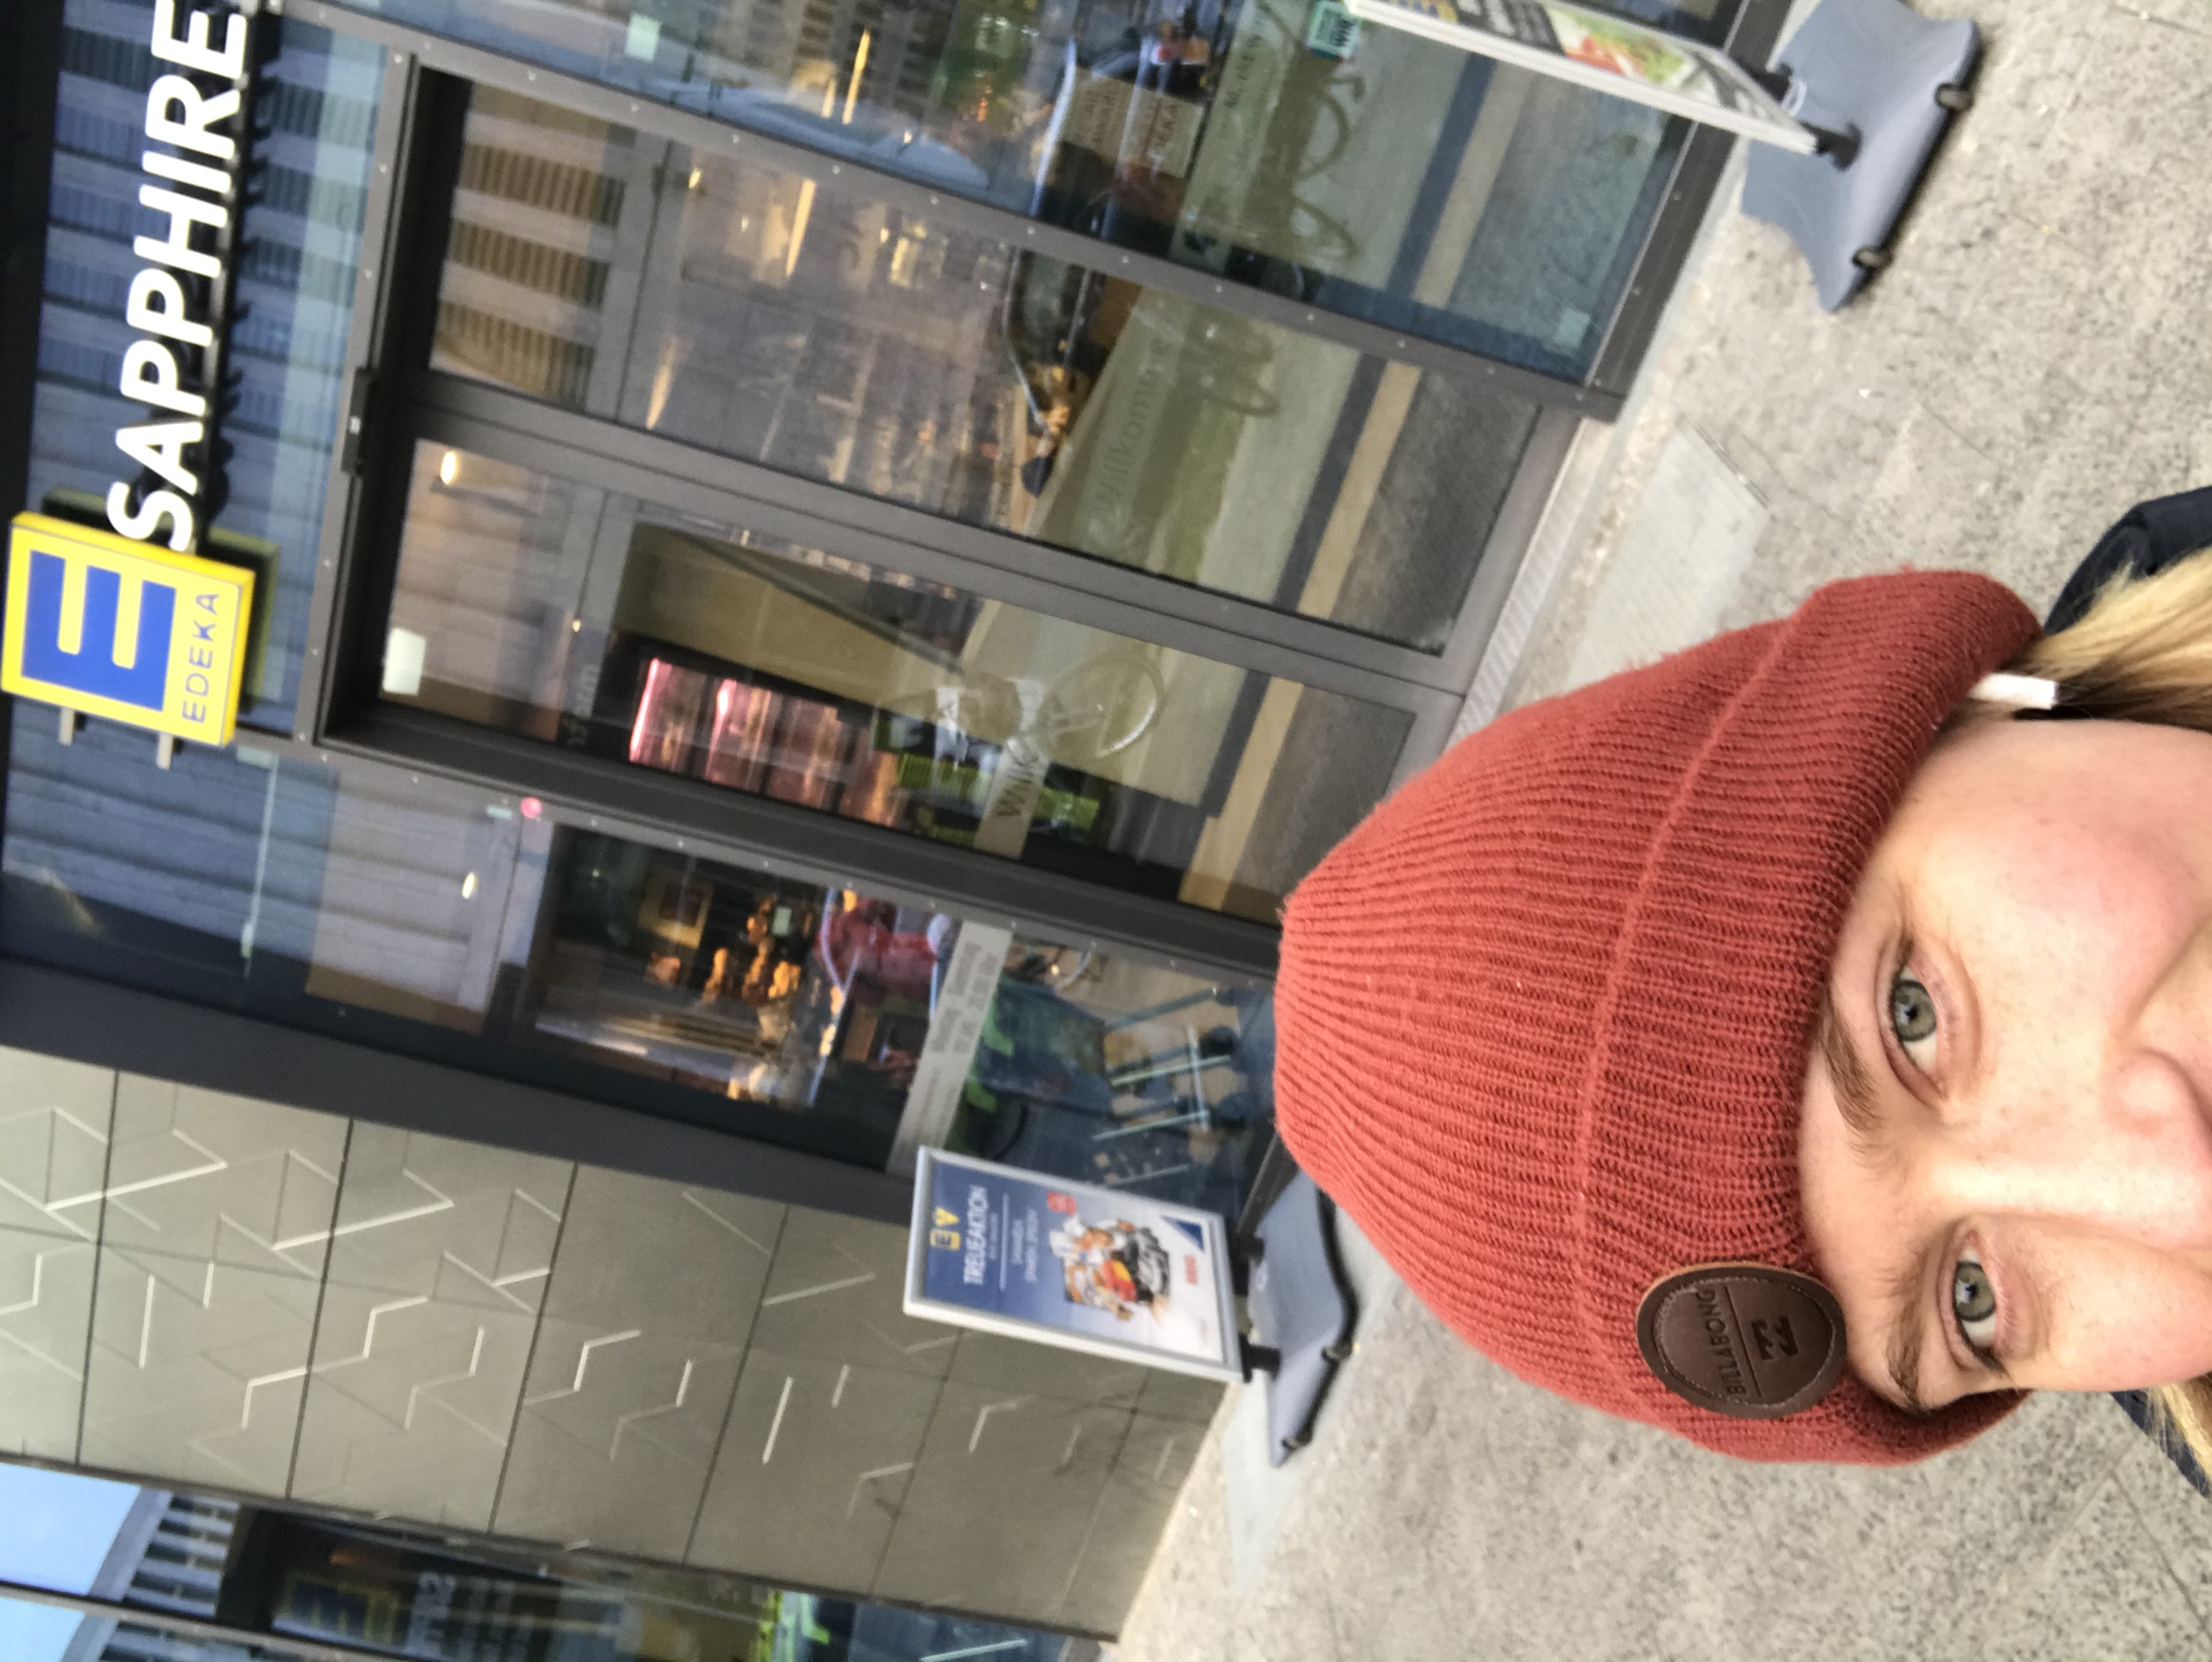

In [165]:
Image("IMG_3646.jpg", width = 300)

# **Preprocessing Data**

The data needs to be processed quite a lot so that it will be possible to use it in a Stan Model. The steps taken for cleaning include:
- Normalising product prices
- Creating a separate data entry for each unique product
- Encoding stores, neighbourhoods, and products as numbers

In [0]:
#Importing relevant packages 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from scipy import stats as sts
import io
import pystan

Note, I performed my initial preprocessing in Google sheets where I normalized all of the data

In [8]:
#upload normalised data 
uploaded = files.upload()

Saving cs146data2.csv to cs146data2.csv


In [128]:
#Lets look at our data 
df1 = pd.read_csv(io.BytesIO(uploaded['cs146data2.csv']))
df1.head()

,Grocery store,Neighbourhood,Apples 1,Apples 2,Apples 3,Bananas1,Bananas 2,Bananas 3,Tomatoes 1,Tomatoes 2,Tomatoes 3,Potatoes 1,Potatoes 2,Potatoes 3,Flour 1,Flour 2,Flour 3,Rice 1,Rice 2,Rice 3,Milk 1,Milk 2,Milk 3,Butter 1,Butter 2,Butter 3,Eggs 1,Eggs 2,Eggs 3,Chicken 1,Chicken 2,Chicken 3
0,EDEKA,Kreuzberg,2.490,2.49,1.66,5.20,2.99,1.09,8.000,4.98,8.00,2.490,0.800000,2.490000,0.99,1.79,1.98,7.1600,2.78,5.980000,0.63,0.71,0.99,1.50,1.38,3.580,0.159,0.119000,0.248333,9.99,8.990,0.00
1,REWE,Schöneberg,1.490,2.49,2.99,1.89,1.99,0.00,4.580,2.19,5.69,0.990,0.880000,0.880000,1.49,0.79,0.39,7.9800,3.98,5.980000,0.63,0.71,1.19,5.60,6.40,7.600,0.199,0.239000,0.290000,9.99,14.000,0.00
2,REWE,Kreuzberg,2.490,1.49,2.19,1.89,0.99,1.69,1.990,3.83,2.76,0.796,1.526667,0.796000,0.39,0.79,0.69,3.9800,1.99,3.975000,0.99,1.39,0.85,3.40,5.00,9.960,0.349,0.481667,0.331667,6.99,9.975,0.00
3,REWE,Alt-Treptow,1.995,2.49,1.49,1.69,0.89,1.45,6.225,4.99,3.96,0.630,1.490000,1.526667,0.59,0.55,1.19,1.4975,4.30,3.316667,0.89,0.99,1.39,3.16,6.36,7.475,0.199,0.439000,0.249000,7.39,8.225,6.99
4,EDEKA,Kreuzberg,3.050,2.49,3.36,1.90,2.20,0.99,3.680,3.36,5.37,1.360,1.240000,1.120000,1.09,1.29,1.59,4.9800,4.49,3.790000,1.39,1.29,1.39,10.76,9.56,8.600,0.375,0.259000,0.498333,8.18,9.110,9.99


In [0]:
#Create separate data entries for each unique product recorded
prices=[]
neighbourhoods=[]
stores = []

#for all rows
for i in range(54):
  #and all product entries 
  for j in range(30):
    prices.append(float(df1.iloc[i,2+j])) #store all prices
    neighbourhoods.append(df1.iloc[i,1]) #store all locations 
    stores.append(df1.iloc[i,0]) #store all stores 

#create the labels for all of the products 

products = ['Apples','Apples','Apples','Bananas','Bananas','Bananas','Tomatoes','Tomatoes','Tomatoes','Potatoes','Potatoes','Potatoes','Flour','Flour','Flour', 'Rice','Rice','Rice','Milk','Milk','Milk','Butter','Butter','Butter','Eggs','Eggs','Eggs','Chicken','Chicken','Chicken']

products = products*54

In [27]:
#put together into a dataframe
d = {'Stores':stores,'Neighbourhoods': neighbourhoods,'Products': products,'Prices': prices}
df = pd.DataFrame(d)
df.head()

,Stores,Neighbourhoods,Products,Prices
0,EDEKA,Kreuzberg,Apples,2.49
1,EDEKA,Kreuzberg,Apples,2.49
2,EDEKA,Kreuzberg,Apples,1.66
3,EDEKA,Kreuzberg,Bananas,5.20
4,EDEKA,Kreuzberg,Bananas,2.99


In [130]:
df.shape #check shape of matrix 

(1452, 4)

In [131]:
#Remove prices that were missing entries 
df = df[(df[['Prices','Products']] != 0).all(axis=1)]
df.shape #we can see we have deleted some columns where we were missing data 

(1452, 4)

In [31]:
#This function changes store names, neighbourhood names
#and product names and changes them to numeric values
#because stan cannot parse strings
def number_id(df, col):
    
    recode = {} #dictionary 
    for column in col: #for each column
        recode[column] = {} #a dictionary for each column
        number_of_values = list(df[column].unique()) #find what needs unique ids
        for i, I_D in enumerate(number_of_values): #for each unique value
            recode[column][i + 1] = I_D #goes to the location in the dictionary 
            df.loc[df[column].values == I_D, column] = i + 1 #recode 
    return(df, recode)

df, recode = number_id(df, 
                  ["Stores", "Neighbourhoods", "Products"]) #recode these cols

#lets see how the data has been recoded                 
display(df.head())

,Stores,Neighbourhoods,Products,Prices
0,1,1,1,2.49
1,1,1,1,2.49
2,1,1,1,1.66
3,1,1,2,5.20
4,1,1,2,2.99


Now that we have cleaned our data, it is time to think about our model.

# **Model**

This model is built to find the observed price of a product. We model this price as a function of the base price of each of our 10 products, a location or neighbourhood multiplier, and a store multiplier.

##**Model Assumptions**


*   The base price of each product is a positive real number. Since we do not know much about the scale, we choose a Cauchy prior because of its broad tails. I chose the location parameter to be 3 and the scale parameter to be 1 to create a prior distribution for base prices that seemed reasonable to me. The peak of the distribution is around 3, and most prices are below 10 which seems reasonable for estimating prices of the products we investigated in Berlin.
*   The store and neighbourhood location multipliers are positive real numbers with priors centered around 1. For both of these priors I chose a log-normal distribution with parameters of $\sigma$ = 0.4, $\mu$=exponent(0).The log-normal distribution was appropriate because it has positive support and is continuous.
* The prices are normally distributed. The center of this distribution is the product of the base price for a product, the store multiplier, and the neighbourhood multiplier. There is a value for $\sigma$ which we will sample from a gamma distribution because of it is continuous and has positive suppport.
* We sample our error term for the likelihood from an inverse gamma distribution with parameters $\alpha=1$ , $\beta=1$ because it is continuous, has positive support, and presents reasonable values for an error term.

###**Mathematically** 



*Parameters:*

Base prices prior: $\text{Cauchy}(p_i|3,1)$ where we have prices $i$ from 1 to 10


Store multipliers prior: $\text{LogNormal}(m_{j}|exp(0),0.4)$. Where we have stores $j$ from 1 to 4 


Neighborhood multipliers prior: $\text{LogNormal}(n_f|0,0.4)$. where we have neighbourhoods $f$ 1 to 9.

Error prior: $\text{Gamma}(\epsilon|1,1)$.


*Likelihood:*


 $\text{Normal}(y_k|p_i*m_j*n_f,\epsilon)$, for $k=1$ to $n$.  $n$ is is the number of data entries. Note that functions map the values for $p,m,n$ to the correct data point.

## **Visualising the priors**

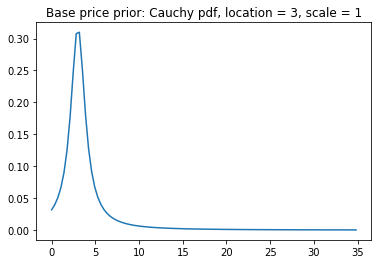

In [132]:
cauchy = sts.cauchy(3, 1)
x = np.linspace(0,cauchy.ppf(0.99), 100)
plt.plot(x, cauchy.pdf(x))
plt.title("Base price prior: Cauchy pdf, location = 3, scale = 1")
plt.show()

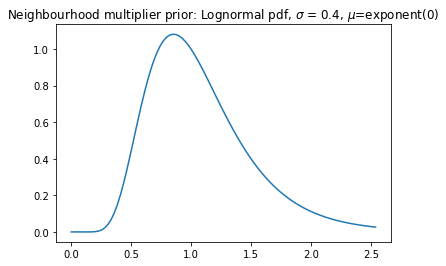

In [133]:
multiplier = sts.lognorm(s=0.4, scale=np.exp(0))
x = np.linspace(0, multiplier.ppf(0.99), 100)
plt.plot(x, multiplier.pdf(x))
plt.title("Neighbourhood multiplier prior: Lognormal pdf, $\sigma$ = 0.4, $\mu$=exponent(0)")
plt.show()

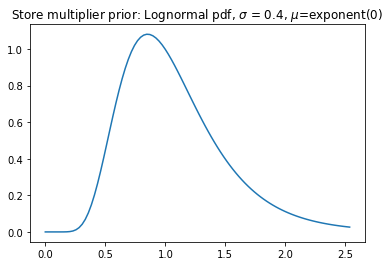

In [134]:
multiplier = sts.lognorm(s=0.4, scale=np.exp(0))
x = np.linspace(0, multiplier.ppf(0.99), 100)
plt.plot(x, multiplier.pdf(x))
plt.title("Store multiplier prior: Lognormal pdf, $\sigma$ = 0.4, $\mu$=exponent(0)")
plt.show()

##**Stan Code**

In [0]:
#Stan model 
stan_code = '''
data {
    int <lower = 0>  n_stores; // number of stores
    int <lower = 0>  n_neighbourhoods; // number of neighbourhoods
    int <lower = 0>  n_products; // number of products
    int <lower = 0>  n_prices; // number of prices
  
    int <lower = 0> stores[n_prices]; // types of stores
    int <lower = 0> neighbourhoods[n_prices]; // each neighbourhood
    int <lower = 0> products[n_prices]; // for each product
    real <lower = 0> prices[n_prices]; // what we predict
    
    real loc;  // fixed prior hyperparameter for cauchy
    real<lower=0> scale;   // fixed prior hyperparameter for cauchy 
    real<lower=0> mu_expon;  // fixed prior hyperparameter for lognormal
    real<lower=0> sig;   // fixed prior hyperparameter for lognormal
    }

parameters {
    real <lower=0>  store_multipliers[n_stores];  // 4 store multipliers
    real <lower=0>  neighbourhood_multipliers[n_neighbourhoods]; // 9 areas
    real <lower=0> base_price[n_products]; // 10 base product prices
    real<lower=0> error; // sigma for likelihood function    
    
}
model {
    // Priors
    base_price ~ cauchy (loc, scale);
    store_multipliers ~ lognormal(mu_expon, sig);
    neighbourhood_multipliers ~ lognormal(mu_expon, sig);
    error ~ inv_gamma(1,1);

    // Normal likelihood
    // for each data entry, calculate a price using the normal distriction
    // centered around the product of base price, store multiplier, and 
    // neighbourhood multiplier. With an error term from a gamma distribution
    for (i in 1:n_prices)  {
        prices[i] ~ normal(base_price[products[i]]*store_multipliers[stores[i]]*\
        neighbourhood_multipliers[neighbourhoods[i]], error);
    }
}

'''

In [151]:
#Compile our model
stan_model = pystan.StanModel(model_code=stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_1a8d6e8312a4cd17192b8319396a7c2f NOW.


In [0]:
#Put data in correct format for stan 
stan_data = {
    "mu_expon": 0,
    "sig":0.4,
    "loc": 3,
    "scale": 1,
    
    "n_stores" : len(df["Stores"].unique()),
    "n_neighbourhoods" : len(df["Neighbourhoods"].unique()),
    "n_prices" : df.shape[0],
    "n_products" : len(df["Products"].unique()),
    
    "stores" : df["Stores"].values,
    "neighbourhoods" : df["Neighbourhoods"].values,
    "products" : df["Products"].values,
    "prices" : df["Prices"].values
    }

In [0]:
#Get results from model
stan_results = stan_model.sampling(data=stan_data)

In [0]:
#Extract samples
samples = stan_results.extract()

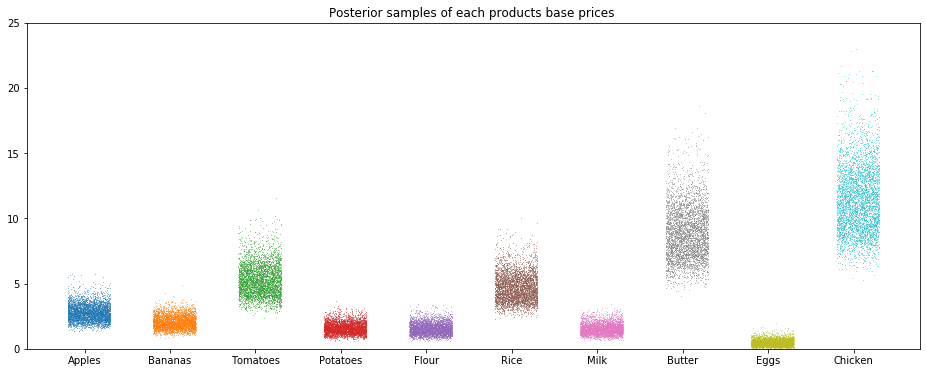

In [154]:
#Plot base price results
plt.figure(figsize=(16,6))
for i in range(10): #for each product
    plt.plot(sts.uniform.rvs(loc=i+0.8, scale=0.5, size=4000), samples['base_price'][:,i], ',', alpha=0.5)
plt.title('Posterior samples of each products base prices ')
plt.xticks([1, 2, 3,4,5,6,7,8,9,10], ['Apples', 'Bananas', 'Tomatoes', 'Potatoes','Flour','Rice','Milk','Butter','Eggs','Chicken'])
plt.ylim(0, 25)
plt.show()

## **What is the basic average price for each product?**





The average base prices for each product are displayed below. The base price does not mean that this is the average price of the product between all the stores, but rather that this base price, along with the neighbourhood multiplier and store multiplier should be used to calculate the expected price of an item in a particular store in a particular neighbourhood.

In [155]:
#Compute average base prices
base = pd.DataFrame({'Average Price':samples["base_price"].mean(axis=0).round(2),
                     'Product': ['Apples', 'Bananas', 'Tomatoes', 'Potatoes',
                      'Flour','Rice','Milk','Butter','Eggs','Chicken']})
display(base[["Product", "Average Price"]])

,Product,Average Price
0,Apples,2.72
1,Bananas,1.99
2,Tomatoes,5.20
3,Potatoes,1.53
4,Flour,1.49
5,Rice,4.62
6,Milk,1.48
7,Butter,8.77
8,Eggs,0.41
9,Chicken,11.33


## **How much does store brand and neighbourhood modify the basic price of the product (up or down)?**

###**Store Brand**

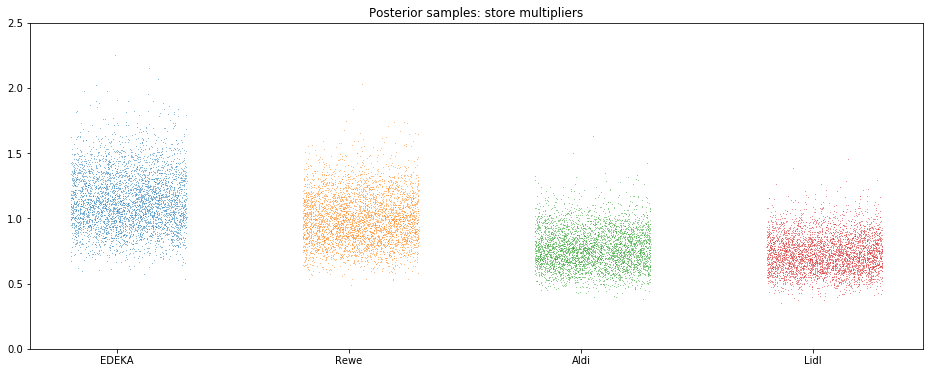

In [156]:
#Plot store multiplier results
plt.figure(figsize=(16,6))
for i in range(4): #for each store
    plt.plot(sts.uniform.rvs(loc=i+0.8, scale=0.5, size=4000), samples['store_multipliers'][:,i], ',', alpha=0.5)
plt.title('Posterior samples: store multipliers')
plt.xticks([1, 2, 3,4], ['EDEKA', 'Rewe', 'Aldi', 'Lidl'])
plt.ylim(0, 2.5)
plt.show()

In [157]:
base2 = pd.DataFrame({'Average Multiplier':samples["store_multipliers"].mean(axis=0).round(2),
                     'Store': ['EDEKA', 'Rewe', 'Aldi', 'Lidl']})
display(base2[["Store", "Average Multiplier"]])

,Store,Average Multiplier
0,EDEKA,1.13
1,Rewe,0.99
2,Aldi,0.76
3,Lidl,0.72


Above, we can see the sampled results for store brand multipliers for each of our 4 stores. We can see that on average, EDEKA is the most expensive store (average multiplier = 1.13) and that Lidl is the cheapest (average multiplier = 0.72). EDEKA's multiplier is greater than 1, and hence increases prices through its multiplication. The values below 1, decrease estimated prices.

###**Neighbourhood multiplier**

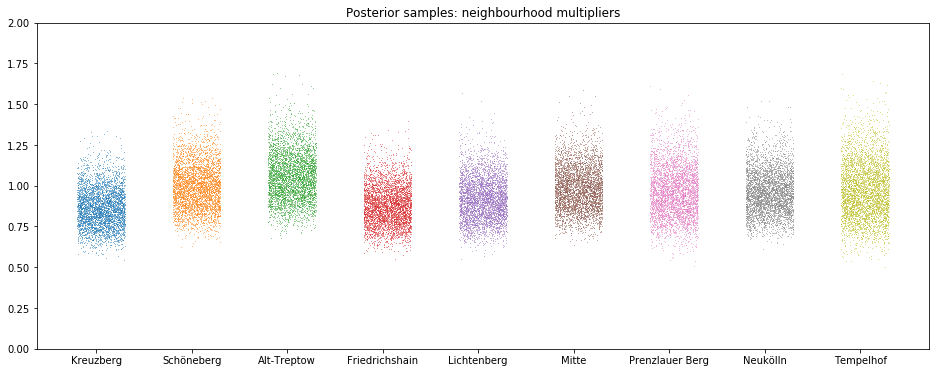

In [158]:
#Plot neighbourhood multiplier results
plt.figure(figsize=(16,6))
for i in range(9): #for each area
    plt.plot(sts.uniform.rvs(loc=i+0.8, scale=0.5, size=4000), samples['neighbourhood_multipliers'][:,i], ',', alpha=0.5)
plt.title('Posterior samples: neighbourhood multipliers')
plt.xticks([1, 2, 3, 4,5,6,7,8,9], ['Kreuzberg', 'Schöneberg', 'Alt-Treptow', 'Friedrichshain','Lichtenberg','Mitte','Prenzlauer Berg','Neukölln','Tempelhof'])
plt.ylim(0, 2)
plt.show()

In [159]:
base3 = pd.DataFrame({'Average Multiplier':samples["neighbourhood_multipliers"].mean(axis=0).round(3),
                     'Neighbourhoods': ['Kreuzberg', 'Schöneberg', 'Alt-Treptow', 'Friedrichshain','Lichtenberg','Mitte','Prenzlauer Berg','Neukölln','Tempelhof']})
display(base3[["Neighbourhoods", "Average Multiplier"]])

,Neighbourhoods,Average Multiplier
0,Kreuzberg,0.860
1,Schöneberg,0.992
2,Alt-Treptow,1.054
3,Friedrichshain,0.874
4,Lichtenberg,0.915
5,Mitte,0.980
6,Prenzlauer Berg,0.957
7,Neukölln,0.958
8,Tempelhof,0.968


Above, we can see the posterior samples of multipliers for each neighbourhood. We can see that on average, the Alt-Treptow multiplier has the greatest increase in price (1.054), whereas Kreuzberg has the lowest average multiplier (0.86). Multipliers that are lower than 1 will decrease the price, whereas multipliers greater than 1 increase the price. Alt-Treptow is the only 'positive' multiplier which drives up prices.

We know that price is a function of the base price for a product, a store multiplier, and a product multiplier. The strongest multipliers, are going to be those which are furthest away from 1, since a multiplier of 1 just keeps price constant.

With this knowledge, we can see that store brand has a bigger effect on price than area does because the multipliers are further away from 1 in general

## **Does price variation by geographical location correlate with variation in rental prices in Berlin, or not?**

I calculated the Monthly Rental prices by using the main station's rental price in the area on the map given to us.

In [160]:
base4 = pd.DataFrame({'Average Monthly Rental Price':[865,787,794,809,739,1044,856,812,755],
                     'Neighbourhoods': ['Kreuzberg', 'Schöneberg', 'Alt-Treptow', 'Friedrichshain','Lichtenberg','Mitte','Prenzlauer Berg','Neukölln','Tempelhof']})
display(base4[["Neighbourhoods", "Average Monthly Rental Price"]])

,Neighbourhoods,Average Monthly Rental Price
0,Kreuzberg,865
1,Schöneberg,787
2,Alt-Treptow,794
3,Friedrichshain,809
4,Lichtenberg,739
5,Mitte,1044
6,Prenzlauer Berg,856
7,Neukölln,812
8,Tempelhof,755


In [161]:
sts.pearsonr(base3["Average Multiplier"],base4["Average Monthly Rental Price"])

(0.02745868418290265, 0.9440967629797004)

We observe a slight positive correlation (3%) between rental prices and neighbourhood multipliers. One would expect that neighbourhoods that have higher rent would have higher multipliers because food prices would also be more expensive. However, given our small dataset, it is probably not very effective to make such claims. Moreover, the rental data is from 2017, which is outdated. A p-value of 0.9 also shows that our results are statistically insignificant and we should not make strong claims based on this result.

# **HCs**

**#variables:** I analyse how the variables (product, store, and neighbourhood) interact to form a function of price. I also explain how multipliers above 1 cause an increase in price, and ones below 1 cause a decrease. This displays knowledge not only of the variables, but of the effect the variables have on the model too.

**#modeling:** I create a model, justify and visualise my assumptions, and implement it in Stan to make predictions. I explain how base price is used in conjunction with location and store brand to make predictions on the price of a specific item.

**#responsibility:** In this assignment, I had to exercise high levels of responsibility. Because the whole class needed to use the data which we collected, we had a deadline of submitting the data the week before. Even though I do not normally start assignments more than a week early, I made sure to carve out time to visit the stores. It was encouraging to see that for the most part, my classmates also submitted their data on time. Students who did not submit by the deadline were not included in my analysis, even if they eventually submitted because I began cleaning the data the day after the deadline. 